# Ephemeris object imaging: continuum (mosaic) - use of updated ephemeris table from JPL-Horizons

This nootebook demonstlates continuum imaging of the ephemeris objects. 
In the following steps first we use the attached ephemeris table(s) 

In [1]:
# extra packages needed
#!pip install astropy
#!pip install aplpy
#!pip instlal ipynb
#!pip install ipympl

In [2]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
from ipynb.fs.defs.ALMAephemimagingVenusMfsMosaicTrackfield import *

In [3]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat, imstat
from casatools import measures, quanta, table, image, msmetadata
import os
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import aplpy
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

In [4]:
datapath='/home/casa/data/casatestdata/measurementset/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [5]:
msfile='venus_ephem_test.ms'
if os.path.exists(msfile):
    os.system(f'cp -r {datapath}{msfile} {msfile}')

## Imaging with external ephemeris table
Following steps describes that imaging with updated ephemeris table which is different from one used to track the source during observation. In that case the stopping of the source image will be done with the updated eph table while the original internal eph table will be used for phase calculation during gridding.

In [6]:
imgname='mosaic-mfs-exteph-venus'

In [7]:
delete_tcleanimages(imgname)

### Get ephemeris table from JPL-Horizons

In [8]:
# use the list obs
listobsout = listobs(msfile)
print(f'obs time (listobs): {listobsout["BeginTime"]} - {listobsout["EndTime"]}')
# Use the same interval as the attached ephemeris table 
inephemtab = get_attachedEphemtablepath(msfile,0)
tb.open(inephemtab)
dmjd = tb.getkeyword('dMJD')
mjd = tb.getcol('MJD')
tb.done()
print(f'MJD range from the internal ephem. table: {mjd[0] } ~ {mjd[-1]}')
cald0 = qa.time(str(mjd[0])+'d',form='ymd')[0]
cald1 = qa.time(str(mjd[-1])+'d',form='ymd')[0]
print(f'calendar date range (internal ephem tab): {cald0} ~ {cald1}')
# 0.0138888 day -> 20min

obs time (listobs): 58491.47346277778 - 58491.485248888894
MJD range from the internal ephem. table: 58491.38888888889 ~ 58491.75
calendar date range (internal ephem tab): 2019/01/08/09:20:00 ~ 2019/01/08/18:00:00


In [9]:
interval = '20m'
#use the same timerange as in the internal table
timerange='2019/01/08/09:20:00 ~ 2019/01/08/18:00:00'

In [10]:
getephemtable(objectname='Venus', timerange=timerange, interval=interval, 
              outfile='Venus_JPL-Horizons_MJD58491.4.tab', overwrite=True)

2024-04-26 20:43:53	WARN	getephemtable::::casa	Venus_JPL-Horizons_MJD58491.4.tab exists, will be overwritten


In [11]:
# Ensure the absolute path for the external table
extephemtabpath=os.path.abspath('Venus_JPL-Horizons_MJD58491.4.tab')
print(extephemtabpath)

/export/home/murasame2/casadev/ephemimaging/demo/notebooks/Venus_JPL-Horizons_MJD58491.4.tab


Now do imaging using the external ephmeris table to stop the image 

In [12]:
ret=tclean(vis=datapath+msfile, field='Venus', imagename=imgname, imsize=[480, 432], cell=['0.14arcsec'], 
           phasecenter=extephemtabpath, specmode='mfs', gridder='mosaic', usepointing=True, niter=100)
ret['iterdone']

100

Convert a CASA image to FITS image for displaying the image via aplpy

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [13]:
# Find the path of the attached ephem. table for fieldid=0
#ephemtab = get_attachedEphemtablepath(msfile,0)
#print(ephemtab)

In [14]:
# Get the first time stamp recorded in the image
from casatasks import imhead
iminfo = imhead(imgname+'.image',mode='list')
print(iminfo['date-obs'])

# find the direction of Venus at reftm
exteph_dir = ephem_dir(extephemtabpath, iminfo['date-obs'], 'ALMA')
ineph_dir = ephem_dir(get_attachedEphemtablepath(msfile,0), iminfo['date-obs'], 'ALMA')
print(exteph_dir)
print(ineph_dir)
exteph_rad = qa.convert(exteph_dir['m0'],'deg')
exteph_decd = qa.convert(exteph_dir['m1'],'deg')
extephmarker = {'extephem':{'ra':exteph_rad['value'], 'dec':exteph_decd['value']}}
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'inephem':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}
markers = {**inephmarker,**extephmarker}
print(markers)

2019/01/08/11:21:50.208000
{'m0': {'unit': 'rad', 'value': -2.1054233331292203}, 'm1': {'unit': 'rad', 'value': -0.29608442174357186}, 'refer': 'ICRS', 'type': 'direction'}
{'m0': {'unit': 'rad', 'value': -2.1053946095161686}, 'm1': {'unit': 'rad', 'value': -0.2960760011918846}, 'refer': 'ICRS', 'type': 'direction'}
{'inephem': {'ra': -120.63022533487045, 'dec': -16.963905283405317}, 'extephem': {'ra': -120.63187107667068, 'dec': -16.96438774547817}}


INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -3.699e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.651e+00 [aplpy.core]
ky=inephem
inephem at: 15:57:28.746, -016.57.50.059
ky=extephem
extephem at: 15:57:28.351, -016.57.51.796
image center: ('15:57:28.351', '-016.57.51.796')


<Figure size 1500x1500 with 0 Axes>

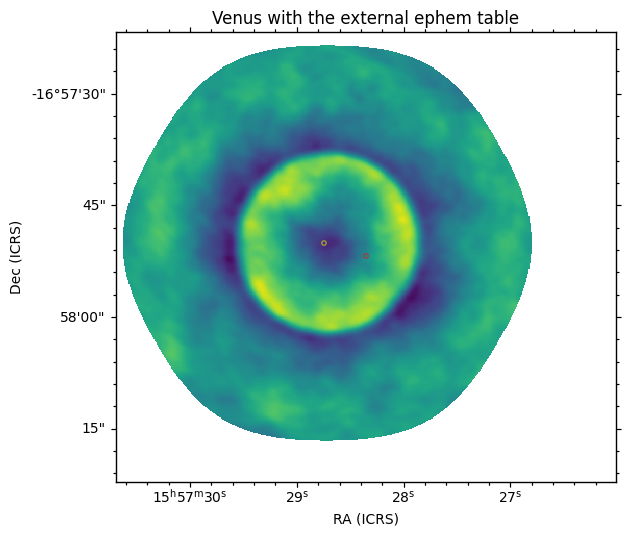

In [15]:
displayImage(imgname+'.image', markers=markers, title='Venus with the external ephem table')

Above image shows the positions directly obtained from the internal (yellow circle) and external (red circle) ephemeris tables

In [16]:
print("internal ephem dir (yellow cirle) = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))
print("external ephem dir (red circle)  = ",qa.time(exteph_dir['m0'],prec=9),qa.angle(exteph_dir['m1'],prec=9))

internal ephem dir (yellow cirle) =  ['15:57:28.746'] ['-016.57.50.059']
external ephem dir (red circle)  =  ['15:57:28.351'] ['-016.57.51.796']


In [17]:
stats = imstat(imgname+'.image')
print(f"{stats['max']}@{stats['maxpos']}")

[3.30854917]@[275 251   0   0]


## Compare the internal and external ephemeris tables

In [18]:
def compare_ephemtable(tab1, tab2):
    """
    Compare two ephemeris tables  
    """
    if os.path.exists(tab1):
        tb.open(tab1)
        mjd1 = tb.getcol('MJD')
        ra1 = tb.getcol('RA')
        dec1 = tb.getcol('DEC')
        tb.done()
    else:
        raise RuntimeError(f'{tab1} does not exist')
    if os.path.exists(tab2):
        tb.open(tab2)
        mjd2 = tb.getcol('MJD')
        ra2 = tb.getcol('RA')
        dec2 = tb.getcol('DEC')
        tb.done()
    else:
        raise RuntimeError(f'{tab2} does not exist')

    tab1name = os.path.basename(tab1)
    tab2name = os.path.basename(tab2)
# plotting
    fig, (ax0,ax1)  = pl.subplots(2,1)
    fig.suptitle(f'{tab2name} - {tab2name} (uncorrected) posisition comparison')
    ax0.scatter(mjd1,ra1, s=10, label=tab1name)
    ax0.scatter(mjd2,ra2, s=10, label=tab2name)
    ax0.set_ylabel('RA [deg]')
    ax0.legend()
    ax1.scatter(mjd1,dec1, s=10)
    ax1.scatter(mjd2,dec2, s=10)
    ax1.set_xlabel('MJD')
    ax1.set_ylabel('Dec [deg]')
    #ax1.legend()
    pl.show()


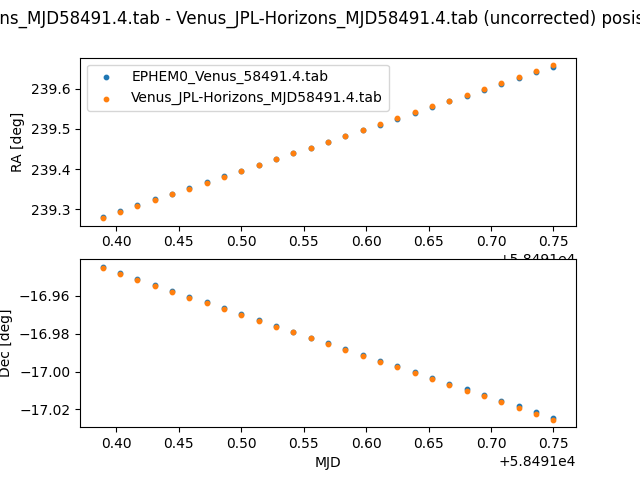

In [19]:
%matplotlib ipympl
compare_ephemtable('venus_ephem_test.ms/FIELD/EPHEM0_Venus_58491.4.tab','Venus_JPL-Horizons_MJD58491.4.tab')